In [2]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


import torch
import numbers
import random
from torch import Tensor


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


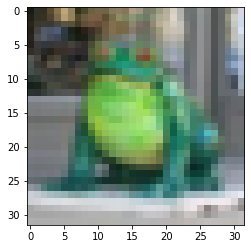

In [3]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

In [4]:
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        # ColourDistortion(s=0.5),
        transforms.ToTensor(),
        # transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])

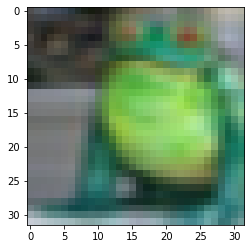

In [16]:
pic = train[19][0]
imshow(transform_train(pic))

# Load batch data for test

In [17]:
t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
for batch_idx, (inputs, _, _) in t:
        x1, x2 = inputs
        x1, x2 = x1.to('cuda'), x2.to('cuda')

Loss: **** ██████████| 98/98 [00:11<00:00,  8.30it/s]


# Final color augmentation class 

In [31]:
class DifferentiableColourDistortionByTorch3(nn.Module):
    
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)


    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value
    
    #### batch color augmentation forward #####
    
    def forward(self, x):
        '''
        Args:
            x: Input tensor batchsize x 32 x 32
        
        Returns:
            x_aug : color jittered image
            
        apply color jitter with prob 0.8
        apply random grayscale with prob 0.2
        
        '''
        batch_size = x.size()[0]
        
        p_jitter = torch.ones(batch_size) * 0.8
        jitter = torch.bernoulli(p_jitter)
        jitter = jitter.reshape(batch_size,1,1,1)

        p_gray = torch.ones(batch_size)* 0.2
        gray = torch.bernoulli(p_gray)
        gray = gray.reshape(batch_size,1,1,1)

        jitter = jitter.to(x.device)
        gray = gray.to(x.device)
        
        #random color jitter
        x_jitter = self.batch_colourjitter(x)
        x = x_jitter * jitter + x *(1-jitter)
        
        #random gray scale
        x_gray = self.batch_rgb_to_grayscale(x).unsqueeze(1)
        x = x_gray * gray + x* (1-gray)
       
        return x
    
    
    def batch_colourjitter(self, img: Tensor) -> Tensor:
        
        fn_idx = torch.randperm(4)
        for fn_id in fn_idx:
            if fn_id == 0 and self.brightness is not None:
                brightness_bound = self.brightness
                img = self.batch_adjust_brightness(img, brightness_bound)

            if fn_id == 1 and self.contrast is not None:
                contrast_bound = self.contrast
                img = self.batch_adjust_contrast(img, contrast_bound)

            if fn_id == 2 and self.saturation is not None:
                saturation_bound = self.saturation
                img = self.batch_adjust_saturation(img, saturation_bound)

            if fn_id == 3 and self.hue is not None:
                hue_bound = self.hue
                img = self.batch_adjust_hue(img, hue_bound)

        return img
        

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string
                
    ##### function from pytorch source code #####
    def _is_tensor_a_torch_image(self, x: Tensor) -> bool:
        return x.ndim >= 2
    
    def _blend(self, img1: Tensor, img2: Tensor, ratio: float) -> Tensor:
        bound = 1 if img1.dtype in [torch.half, torch.float32, torch.float64] else 255
        return (ratio * img1 + (1 - ratio) * img2).clamp(0, bound).to(img1.dtype)
    
    # batch adjust brightness
    def batch_adjust_brightness(self,img: Tensor, brightness_bound: list) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        B = img.size()[0]
        brightness_list = torch.torch.rand(B)*(brightness_bound[1] - brightness_bound[0]) + brightness_bound[0]
        brightness_factor = brightness_list.reshape(B,1,1,1).to(img.device)
        return self._blend(img, torch.zeros_like(img), brightness_factor)
    
    def batch_rgb_to_grayscale(self,img: Tensor) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        if img.shape[1] != 3:
            raise TypeError('Input Image does not contain 3 Channels')

        img_tp = img.transpose(0,1)
        img_gray = (0.2989 * img_tp[0] + 0.5870 * img_tp[1] + 0.1140 * img_tp[2])
        return img_gray
    
    def batch_adjust_saturation(self,img: Tensor, saturation_bound: list) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''

        B = img.size()[0]
        saturation_list = torch.torch.rand(B)*(saturation_bound[1] - saturation_bound[0]) + saturation_bound[0]
        saturation_factor = saturation_list.reshape(B,1,1,1).to(img.device)
    #     print(saturation_factor.size())

        return self._blend(img, self.batch_rgb_to_grayscale(img).unsqueeze(1), saturation_factor)
    
    def batch_adjust_contrast(self,img: Tensor, contrast_bound: float) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        B = img.size()[0]
        contrast_list = torch.torch.rand(B)*(contrast_bound[1] - contrast_bound[0]) + contrast_bound[0]
        contrast_list = contrast_list.reshape(B,1,1,1).to(img.device)

        #mean for each pic (over HxW points)
        img_gray = self.batch_rgb_to_grayscale(img)
        mean = torch.mean(img_gray.reshape(img_gray.shape[0],-1), dim = 1)


        return self._blend(img, mean.reshape([mean.size()[0],1,1,1]),  contrast_list)
    
    def batch_adjust_hue(self, img: Tensor, hue_bound: list) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''

        B = img.size()[0]
        theta = (torch.torch.rand(B)*(hue_bound[1]-hue_bound[0]) + hue_bound[0])* 3.1415* 2

        # generate tensor 
        one_tensor = torch.ones(B)
        zero_tensor = torch.zeros(B)
        cos_tensor = torch.cos(theta)
        sin_tensor = torch.sin(theta)

        #stack
        T_hue = torch.stack([one_tensor, zero_tensor, zero_tensor,
                     zero_tensor, cos_tensor, -sin_tensor,
                     zero_tensor, sin_tensor, cos_tensor]).transpose(0,1).reshape(B,3,3)

        T_yiq = torch.tensor([[0.299, 0.587, 0.114], [0.596, -0.274, -0.321], [0.211, -0.523, 0.311]])
        T_rgb = torch.tensor([[1, 0.956, 0.621], [1, -0.272, -0.647], [1, -1.107, 1.705]])
        T_final = torch.matmul(torch.matmul(T_rgb, T_hue), T_yiq)
        T_final = T_final.to(img.device)

        #return T_rgb x T_hue x T_yiq x img

        return torch.matmul(T_final.unsqueeze(1).unsqueeze(1), img.transpose(1,-1).unsqueeze(-1)).squeeze(-1).transpose(1,-1)

    
    


In [32]:
aug =  DifferentiableColourDistortionByTorch3(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)
aug_x1 = aug(x1)

In [33]:
aug_x1.size()

torch.Size([336, 3, 32, 32])

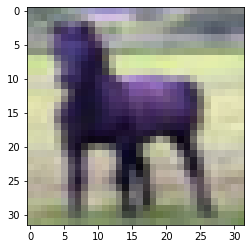

In [34]:
imshow(x1[0].to('cpu'))

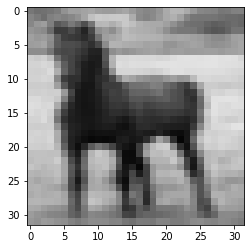

In [35]:
imshow(aug_x1[0].to('cpu'))

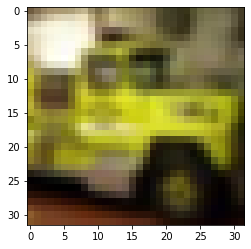

In [36]:
imshow(x1[1].to('cpu'))

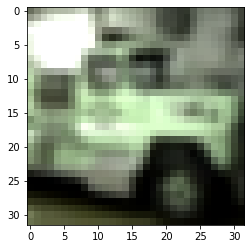

In [37]:
imshow(aug_x1[1].to('cpu'))

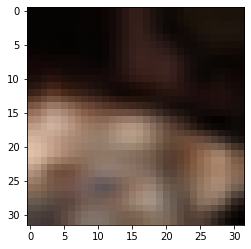

In [38]:
imshow(x1[7].to('cpu'))

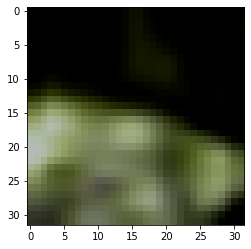

In [39]:
imshow(aug_x1[7].to('cpu'))